In [1]:
!pip install kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 97% 25.0M/25.7M [00:01<00:00, 30.9MB/s]
100% 25.7M/25.7M [00:01<00:00, 21.3MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
data = pd.read_csv('IMDB Dataset.csv')

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Enlever les balises HTML
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Enlever la ponctuation
    text = text.lower()  # Passage en minuscules
    text = text.strip()  # Enlever les espaces en trop
    tokens = text.split()  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Enlever les stopwords et lemmatisation
    return ' '.join(tokens)

data['review'] = data['review'].apply(clean_text)

# Tokenisation lemmatisation et padding

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

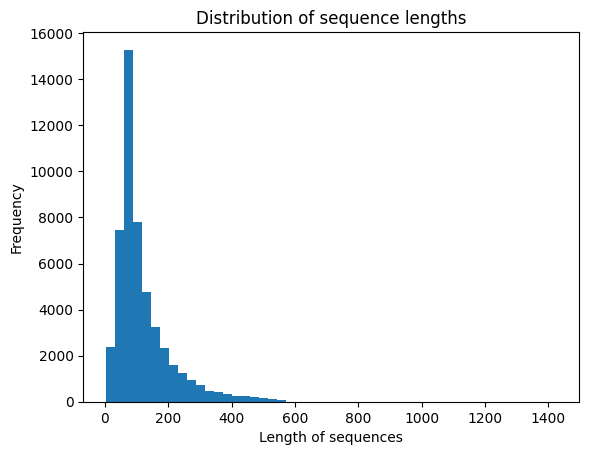

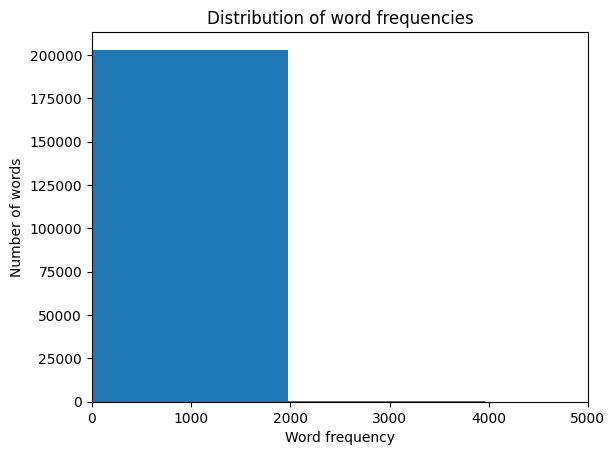

In [7]:
# Tokenisation et séquence des mots
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])

# Histogramme de la longueur des séquences de mots
seq_lengths = [len(seq) for seq in sequences]
plt.hist(seq_lengths, bins=50)
plt.xlabel('Length of sequences')
plt.ylabel('Frequency')
plt.title('Distribution of sequence lengths')
plt.show()

# Histogramme des fréquences des mots différents
word_counts = tokenizer.word_counts.values()
plt.hist(word_counts, bins=50)
plt.xlabel('Word frequency')
plt.ylabel('Number of words')
plt.title('Distribution of word frequencies')
plt.xlim([0, 5000])
plt.show()


In [8]:
# Compter la fréquence des mots
word_counts = tokenizer.word_counts

# Filtrer les mots ayant moins de 5 occurrences
filtered_word_counts = {word: count for word, count in word_counts.items() if count >= 5}
tokenizer.word_counts = filtered_word_counts

# Mettre à jour les index des mots dans le tokenizer après le filtrage
tokenizer.word_index = {word: i+1 for i, (word, count) in enumerate(filtered_word_counts.items())}

print(len(filtered_word_counts))

38690


In [9]:
max_words = 38690 
max_len = 500 

# Padding des séquences
X = pad_sequences(sequences, maxlen=max_len)

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
# Encodage des labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])

# Modèle LSTM

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [13]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

In [15]:
# Définition du modèle LSTM
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # un neurone avec sigmoide
])

# Compilation du modèle
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
# Entraînement du modèle
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
500/500 [==============================] - 67s 123ms/step - loss: 0.3804 - accuracy: 0.8312 - val_loss: 0.3291 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 48s 96ms/step - loss: 0.1914 - accuracy: 0.9304 - val_loss: 0.3128 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 37s 74ms/step - loss: 0.1112 - accuracy: 0.9617 - val_loss: 0.3758 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 31s 61ms/step - loss: 0.0814 - accuracy: 0.9725 - val_loss: 0.4073 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 32s 64ms/step - loss: 0.0508 - accuracy: 0.9836 - val_loss: 0.4146 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 28s 56ms/step - loss: 0.0386 - accuracy: 0.9879 - val_loss: 0.5337 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 7/100
500/500 [==============================

In [17]:
# Sauvegarde du modèle
model_lstm.save('model_lstm.h5')

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

313/313 [==============================] - 5s 14ms/step
Accuracy: 0.8569
Precision: 0.8394806172374859
Recall (Sensitivity): 0.8852947013296288
Specificity: 0.8280588591009878
F1 Score: 0.8617791944363953


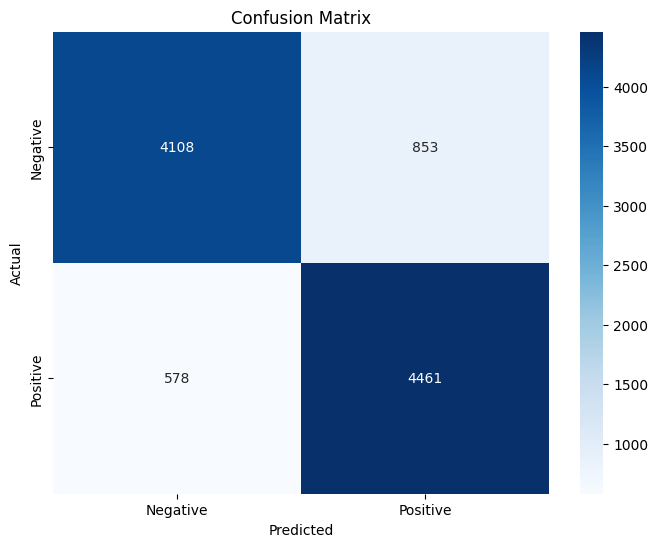

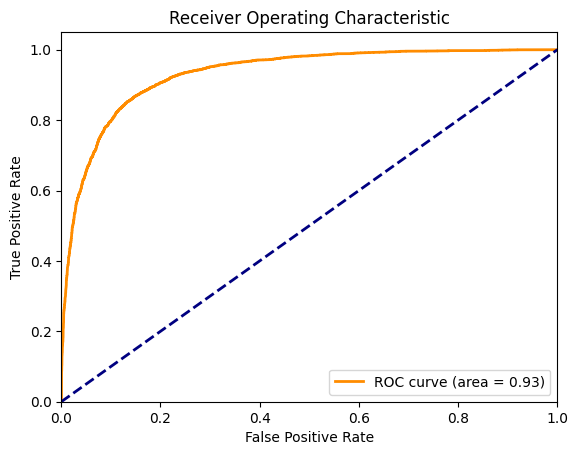

In [19]:
# Évaluation du modèle
y_pred = model_lstm.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Seuil de 0.5 pour la classification binaire

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# Métriques de performance
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
specificity = tn / (tn + fp)  # Spécificité
sensitivity = recall  # Sensibilité est la même que le rappel (recall)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {recall}')
print(f'Specificity: {specificity}')
print(f'F1 Score: {f1}')

#Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Courbe ROC et AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

#Affichage
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [20]:
def clean_text_com(text):
    text = re.sub(r'<.*?>', '', text) #Supprimer HTML
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) #Supprimer la ponctuation
    text = text.lower() #Texte en minuscules 
    text = text.strip() #Supprimer les espaces en trop
    tokens = text.split() #Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] #Supprimer les stopwords et lemmatisation
    cleaned_text = ' '.join(tokens) #Rejoindre tokens en une string
    sequences = tokenizer.texts_to_sequences([cleaned_text]) #Transformer le texte en séquence de tokens
    padded_sequence = pad_sequences(sequences, maxlen=500)  #Padding
    return padded_sequence

def predict_sentiment(text):
    processed_text = clean_text_com(text)
    prediction = model_lstm.predict(processed_text)
    predicted_class = (prediction > 0.5).astype(int)
    sentiment = label_encoder.inverse_transform(predicted_class)
    return sentiment

In [23]:
# Exemple d'utilisation
commentaire_positif = "This movie was absolutely amazing, I loved it!"
commentaire_negatif = "I hated this movie, it was lame."
sentiment_positif = predict_sentiment(commentaire_positif)
sentiment_negatif = predict_sentiment(commentaire_negatif)
print(f"Le sentiment du commentaire positif est : {sentiment_positif}")
print(f"Le sentiment du commentaire negatif est : {sentiment_negatif}")

1/1 [==============================] - 0s 56ms/step
Le sentiment du commentaire positif est : ['positive']
Le sentiment du commentaire negatif est : ['negative']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# LSTM avec attention